In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
from tqdm import tqdm
%matplotlib inline

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [4]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 100 # hz
pg_fr = 8 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [5]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [6]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

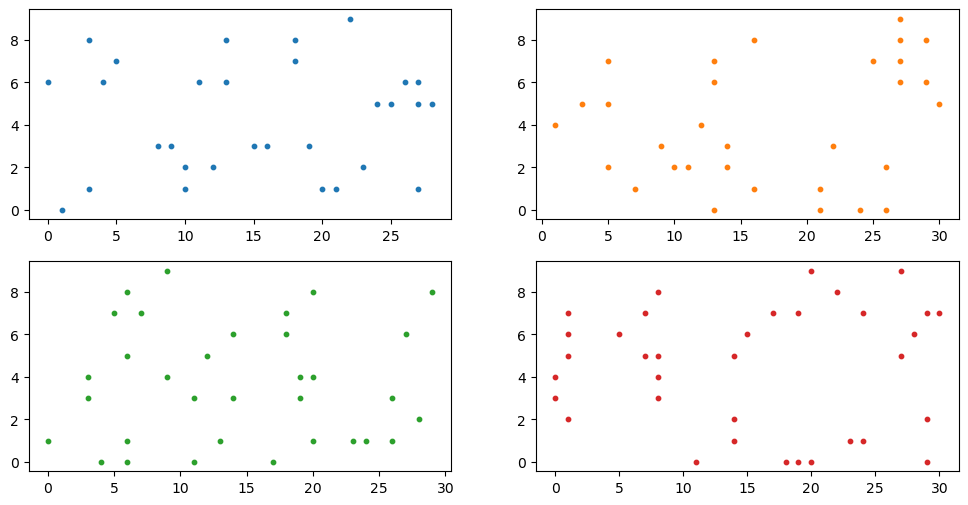

In [7]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [8]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [9]:
B_sparse[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3], dtype=int64)

In [10]:
colors[B_sparse[0]]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c', '#2ca02c',
       '#2ca02c', '#2ca02c', '#d62728', '#d62728', '#d62728', '#d62728',
       '#d62728', '#d62728'], dtype='<U7')

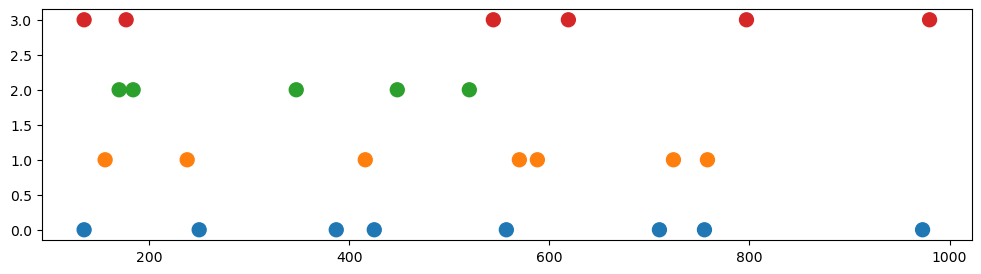

In [11]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [12]:
background_noise_fr

0

In [13]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

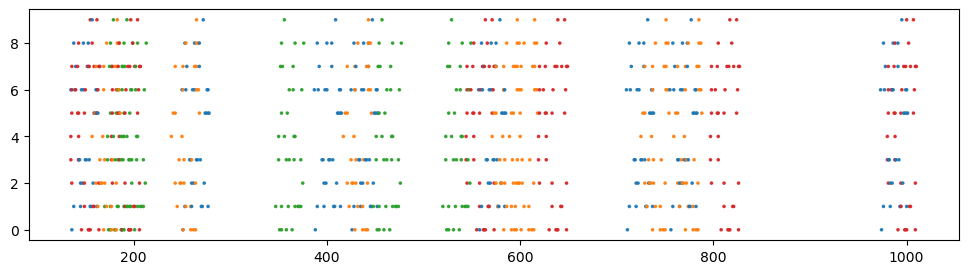

In [34]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=10,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

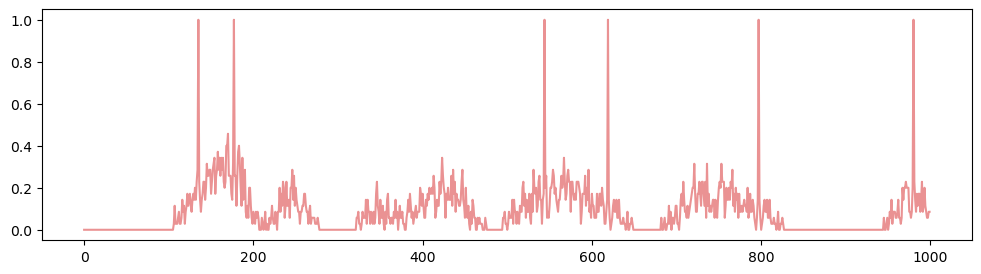

In [15]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

In [16]:
depth = 15
t=150
A_sparse[1][(A_sparse[0]==0) & (A_sparse[1] > t-depth) & (A_sparse[1] < t+depth)]

array([136, 146, 153, 154, 155, 164], dtype=int64)

In [22]:
np.arange(20)[(np.arange(20) > 5) & (np.arange(20) <= 15)]

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14])

In [28]:
window = 15
av_hists = np.zeros((N,N),dtype='object')
for trigger_neuron in range(N):
    for response_neuron in range(N):
        stacked_responses = np.array([])
        for trigger_spike in A_sparse[1][A_sparse[0]==trigger_neuron ]:
            response_spikes = trigger_spike - A_sparse[1][(A_sparse[0]==response_neuron)  & (A_sparse[1] > trigger_spike-window) & (A_sparse[1] <= trigger_spike+window)]
            stacked_responses = np.hstack((stacked_responses, response_spikes))
        av_hists[trigger_neuron][response_neuron] = stacked_responses

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.32it/s]


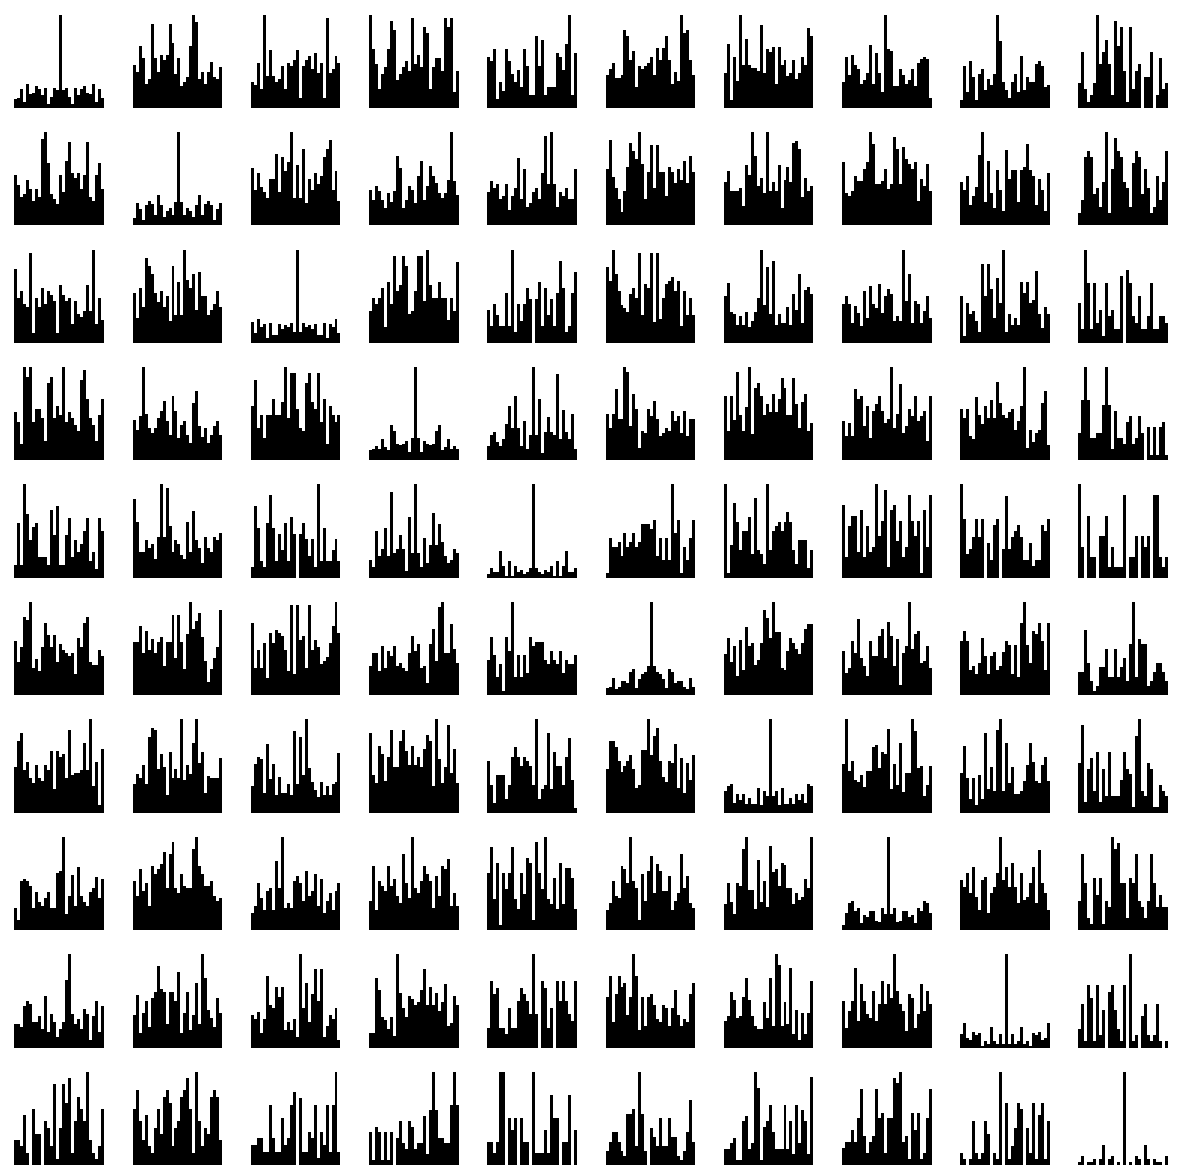

In [38]:
%matplotlib inline
fig, axs = plt.subplots(10, 10,  figsize=(15, 15))
for i in tqdm(range(len(av_hists))):
    for j in range(len(av_hists)):
        axs[i][j].hist(av_hists[i][j],bins=depth*2,color='black')
        axs[i][j].axis('off')
#     axs[i][i].set_xticks([])
#     axs[i][i].set_yticks([])
plt.show()


What happens if I just look at the histograms for each motif?

In [42]:
window = 15
motif=0
av_hists = np.zeros((N,N),dtype='object')
for trigger_neuron in range(N):
    for response_neuron in range(N):
        stacked_responses = np.array([])
        for trigger_spike in A_sparse[1][(A_sparse[0]==trigger_neuron) & (A_sparse[2]==motif)]:
            response_spikes = trigger_spike - A_sparse[1][(A_sparse[0]==response_neuron)  & (A_sparse[1] > trigger_spike-window) & (A_sparse[1] <= trigger_spike+window) & (A_sparse[2]==motif)]
            stacked_responses = np.hstack((stacked_responses, response_spikes))
        av_hists[trigger_neuron][response_neuron] = stacked_responses

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


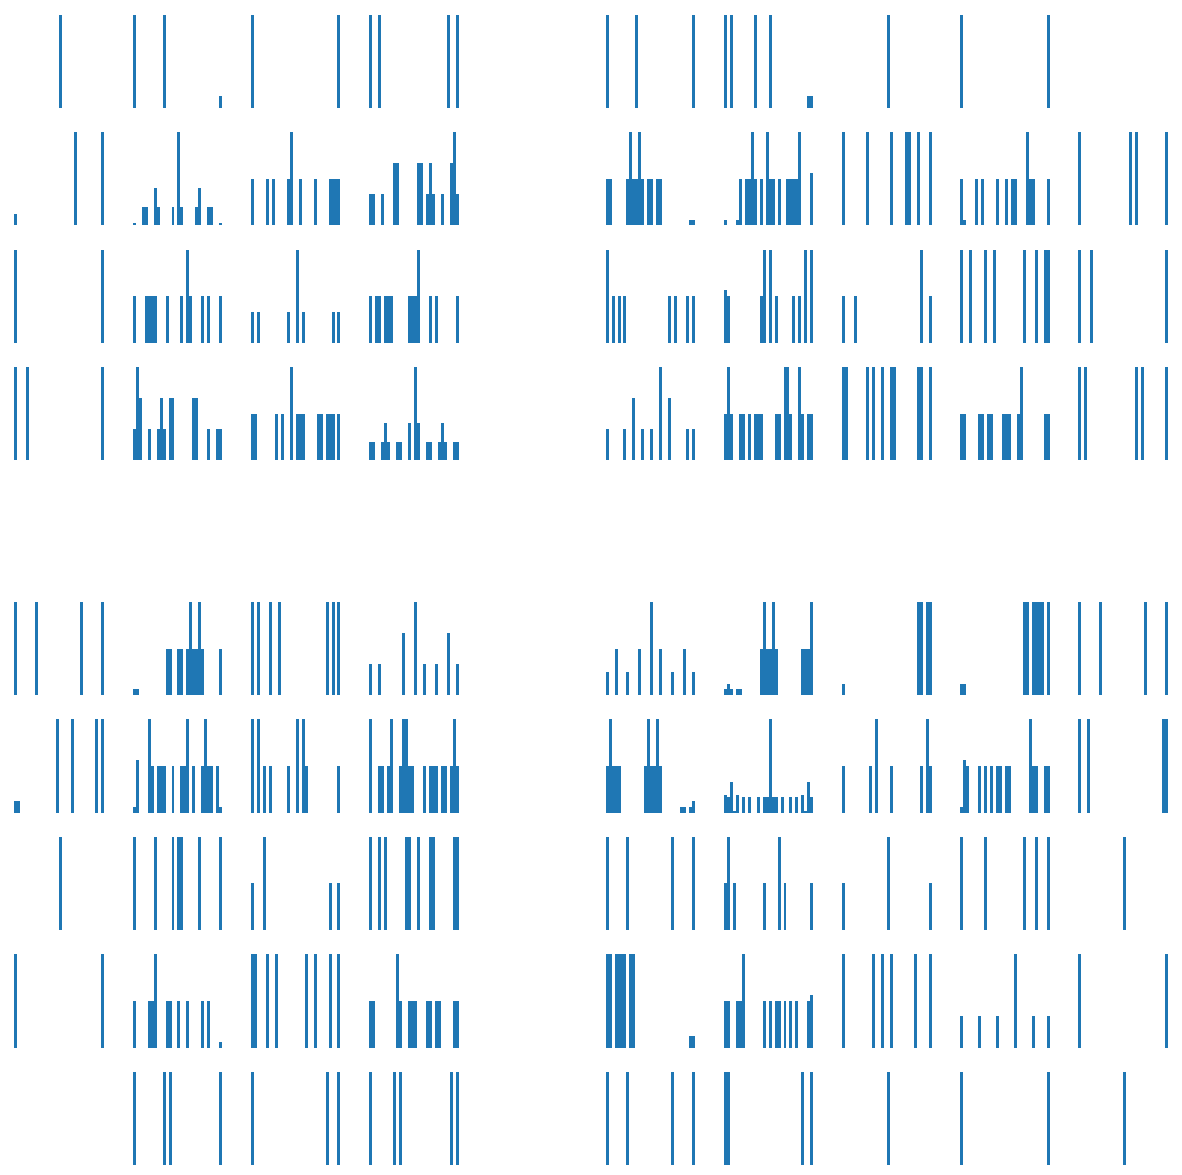

In [43]:
%matplotlib inline
fig, axs = plt.subplots(10, 10,  figsize=(15, 15))
for i in tqdm(range(len(av_hists))):
    for j in range(len(av_hists)):
        axs[i][j].hist(av_hists[i][j],bins=depth*2,color=colors[motif])
        axs[i][j].axis('off')
#     axs[i][i].set_xticks([])
#     axs[i][i].set_yticks([])
plt.show()


It would be better if I could store histograms per spike, instead of taking the average... hmmmm

In [32]:
A_sparse[0].shape # This would result in 830 histograms... but I may be able to reduce the dimensionality by 

(830,)

In [37]:
[len(A_sparse[0][(A_sparse[0]==i)]) for i in range(N)]

[86, 113, 82, 98, 46, 93, 108, 101, 71, 32]